In [80]:
from pathlib import Path

import polars as pl
import polars.selectors as cs
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [81]:
def get_data_dict(fitbitdata_directory: Path) -> dict[str, list[Path]]:
    """
    Traverse the specified directory to collect CSV and JSON files, organizing them by their parent directory names.

    Parameters:
    fitbitdata_directory (Path): The root directory containing subdirectories with CSV files.

    Returns:
    Dict[str, List[Path]]: A dictionary where each key is the name of a subdirectory, and the corresponding value is a list of Paths to the CSV files within that subdirectory.

    """

    data_collection = {}

    for subdir in fitbitdata_directory.glob("*"):
        for file in subdir.glob("*[.csv,.json]"):
            topic = subdir.parts[-1]
            if topic in data_collection.keys():
                data_collection[topic].append(file)
            else:
                data_collection[topic] = [file]

    return data_collection


def plot_timeseries(
    df: pl.DataFrame,
    timestamp_col: str,
    mean_col: str,
    quantile_cols: dict | None = None,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    legend: bool = True,
):
    """
    Plots a time series with mean values and shaded quantile ranges.

    Parameters:
    - df: polars.DataFrame
        The DataFrame containing the data.
    - timestamp_col: str
        The name of the column containing timestamp data.
    - mean_col: str
        The name of the column containing mean values to plot.
    - quantile_cols: dict, optional
        A dictionary specifying the quantile columns to shade, with keys as labels and values as tuples of (lower_quantile_col, upper_quantile_col).
        Example: {'IQR (25th to 75th percentile)': ('rmssd_Q25%', 'rmssd_Q75%')}
    - xlabel: str, optional
        Label for the x-axis.
    - ylabel: str, optional
        Label for the y-axis.
    - title: str, optional
        Title of the plot.
    """

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=timestamp_col, y=mean_col, label=mean_col, color="blue")

    if quantile_cols:
        for label, (lower_col, upper_col) in quantile_cols.items():
            if lower_col in df.columns and upper_col in df.columns:
                plt.fill_between(
                    df[timestamp_col],
                    df[lower_col],
                    df[upper_col],
                    alpha=0.3,
                    label=label,
                )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)

    if legend:
        plt.legend()

    plt.tight_layout()

    plt.show()


def plot_time_series_all_columns(
    df: pl.DataFrame, time_column: str, date_column: str = None, legend: bool = False
):
    """
    Plots all numeric columns in a Polars DataFrame against a specified time column.

    Parameters:
    - df: pl.DataFrame
        Polars DataFrame containing the data to plot.
    - time_column: str
        The column name representing the timestamp for the x-axis.
    - date_column: str, optional
        An optional column for date to aggregate by or display if available.

    Returns:
    None
    """
    # Ensure time column is datetime type
    if time_column not in df.columns:
        raise ValueError(f"{time_column} is not a valid column in the DataFrame.")

    if not isinstance(df[time_column].dtype, pl.Datetime):
        raise ValueError(f"{time_column} is not of datetime type.")

    # Select numeric columns
    numeric_columns = [
        col
        for col, dtype in zip(df.columns, df.schema.values())
        if dtype.is_numeric() and col not in {time_column, date_column}
    ]

    if not numeric_columns:
        raise ValueError("No numeric columns found in the DataFrame to plot.")

    # Convert the DataFrame to pandas for plotting
    pandas_df = df.to_pandas()

    # Set up the figure
    plt.figure(figsize=(14, len(numeric_columns) * 3))

    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(len(numeric_columns), 1, i)
        plt.plot(pandas_df[time_column], pandas_df[col], label=col, alpha=0.8)
        plt.title(col[0].upper() + col[1:])
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.grid(True)
        if date_column and date_column in pandas_df.columns:
            plt.xticks(pandas_df[time_column][:: len(pandas_df) // 10], rotation=45)
        else:
            plt.xticks(rotation=45)
        if legend:
            plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

In [82]:
project = Path().home().cwd()

if project.parts[-1] != "fitbitData":
    project = project.parent


data = project / "data"
fitbitdata = data / "Takeout" / "Fitbit"
libre3data = data / "libre3"

data_collection = get_data_dict(fitbitdata)

In [83]:
step_files = filter(
    lambda p: "steps" in p.parts[-1], data_collection["Physical Activity_GoogleData"]
)

query = pl.scan_csv(list(step_files), schema_overrides={"timestamp": pl.Datetime})

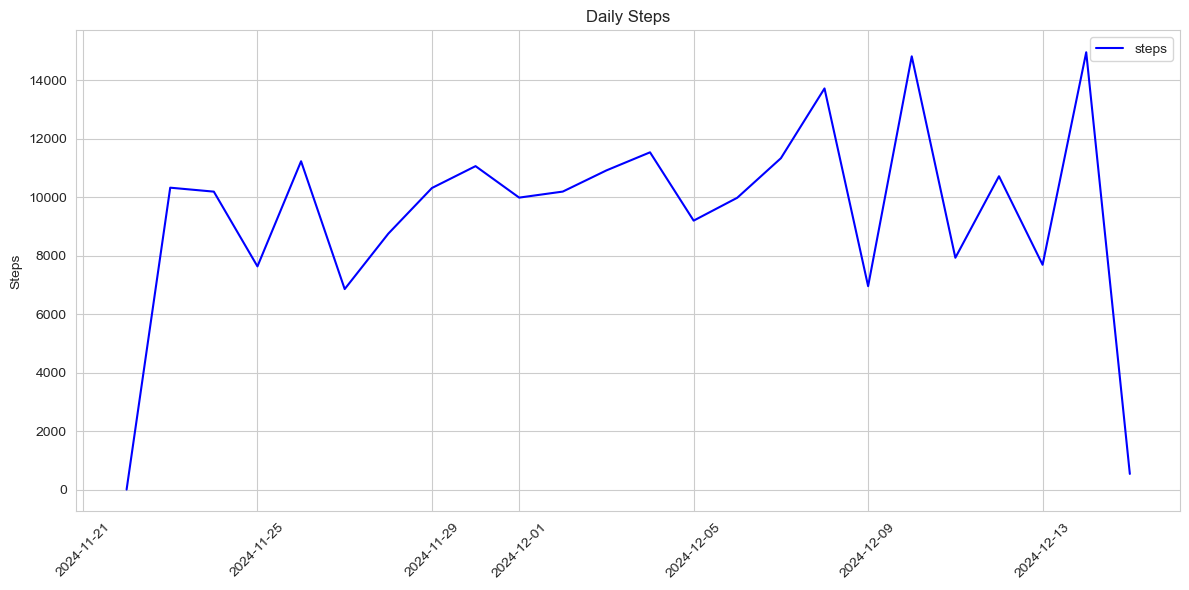

In [84]:
query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("steps").sum()
)

steps_df = query.collect()

plot_timeseries(
    df=steps_df,
    timestamp_col="timestamp",
    mean_col="steps",
    xlabel="",
    ylabel="Steps",
    title="Daily Steps",
    legend=False,
)

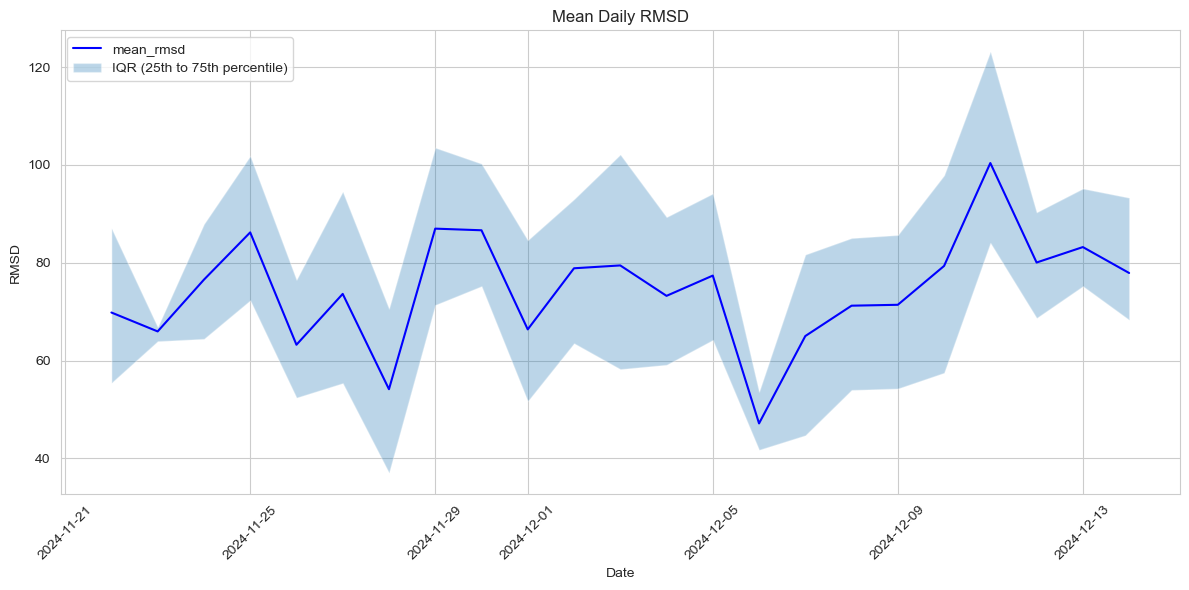

In [85]:
hrv_files = filter(
    lambda p: "Heart Rate Variability Details" in p.parts[-1],
    data_collection["Heart Rate Variability"],
)


query = pl.scan_csv(list(hrv_files), schema_overrides={"timestamp": pl.Datetime}).sort(
    by="timestamp"
)

query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("rmssd").mean().alias("mean_rmsd"),
    pl.col("rmssd").quantile(0.25).name.suffix("_Q25%"),
    pl.col("rmssd").quantile(0.5).name.suffix("_Q50%"),
    pl.col("rmssd").quantile(0.75).name.suffix("_Q75%"),
    pl.col("rmssd").quantile(1).name.suffix("_Q100%"),
)


hrv_df = query.collect()

quantile_columns = {
    "IQR (25th to 75th percentile)": ("rmssd_Q25%", "rmssd_Q75%"),
}

plot_timeseries(
    df=hrv_df,
    timestamp_col="timestamp",
    mean_col="mean_rmsd",
    quantile_cols=quantile_columns,
    xlabel="Date",
    ylabel="RMSD",
    title="Mean Daily RMSD",
)

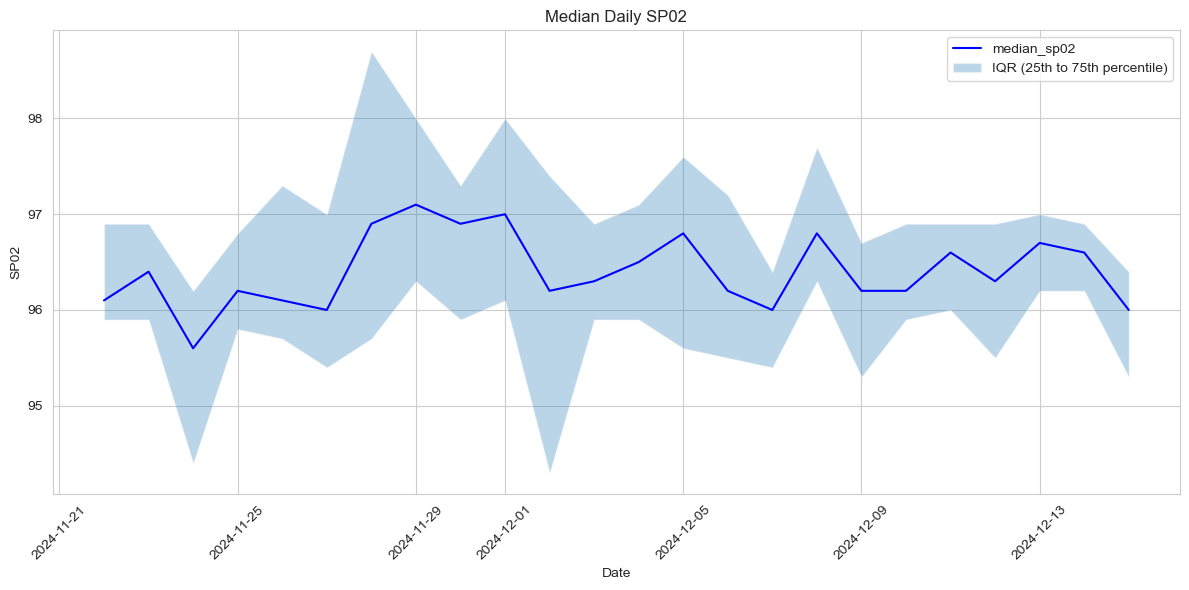

In [86]:
sp02_files = filter(
    lambda p: "Minute SpO2" in p.parts[-1], data_collection["Oxygen Saturation (SpO2)"]
)


query = (
    pl.scan_csv(list(sp02_files), schema_overrides={"timestamp": pl.Datetime})
    .sort(by="timestamp")
    .rename({"value": "sp02"})
)

query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("sp02").median().alias("median_sp02"),
    pl.col("sp02").quantile(0.25).name.suffix("_Q25%"),
    pl.col("sp02").quantile(0.5).name.suffix("_Q50%"),
    pl.col("sp02").quantile(0.75).name.suffix("_Q75%"),
    pl.col("sp02").quantile(1).name.suffix("_Q100%"),
)


sp02_df = query.collect()

quantile_columns = {
    "IQR (25th to 75th percentile)": ("sp02_Q25%", "sp02_Q75%"),
}

plot_timeseries(
    df=sp02_df,
    timestamp_col="timestamp",
    mean_col="median_sp02",
    quantile_cols=quantile_columns,
    xlabel="Date",
    ylabel="SP02",
    title="Median Daily SP02",
)

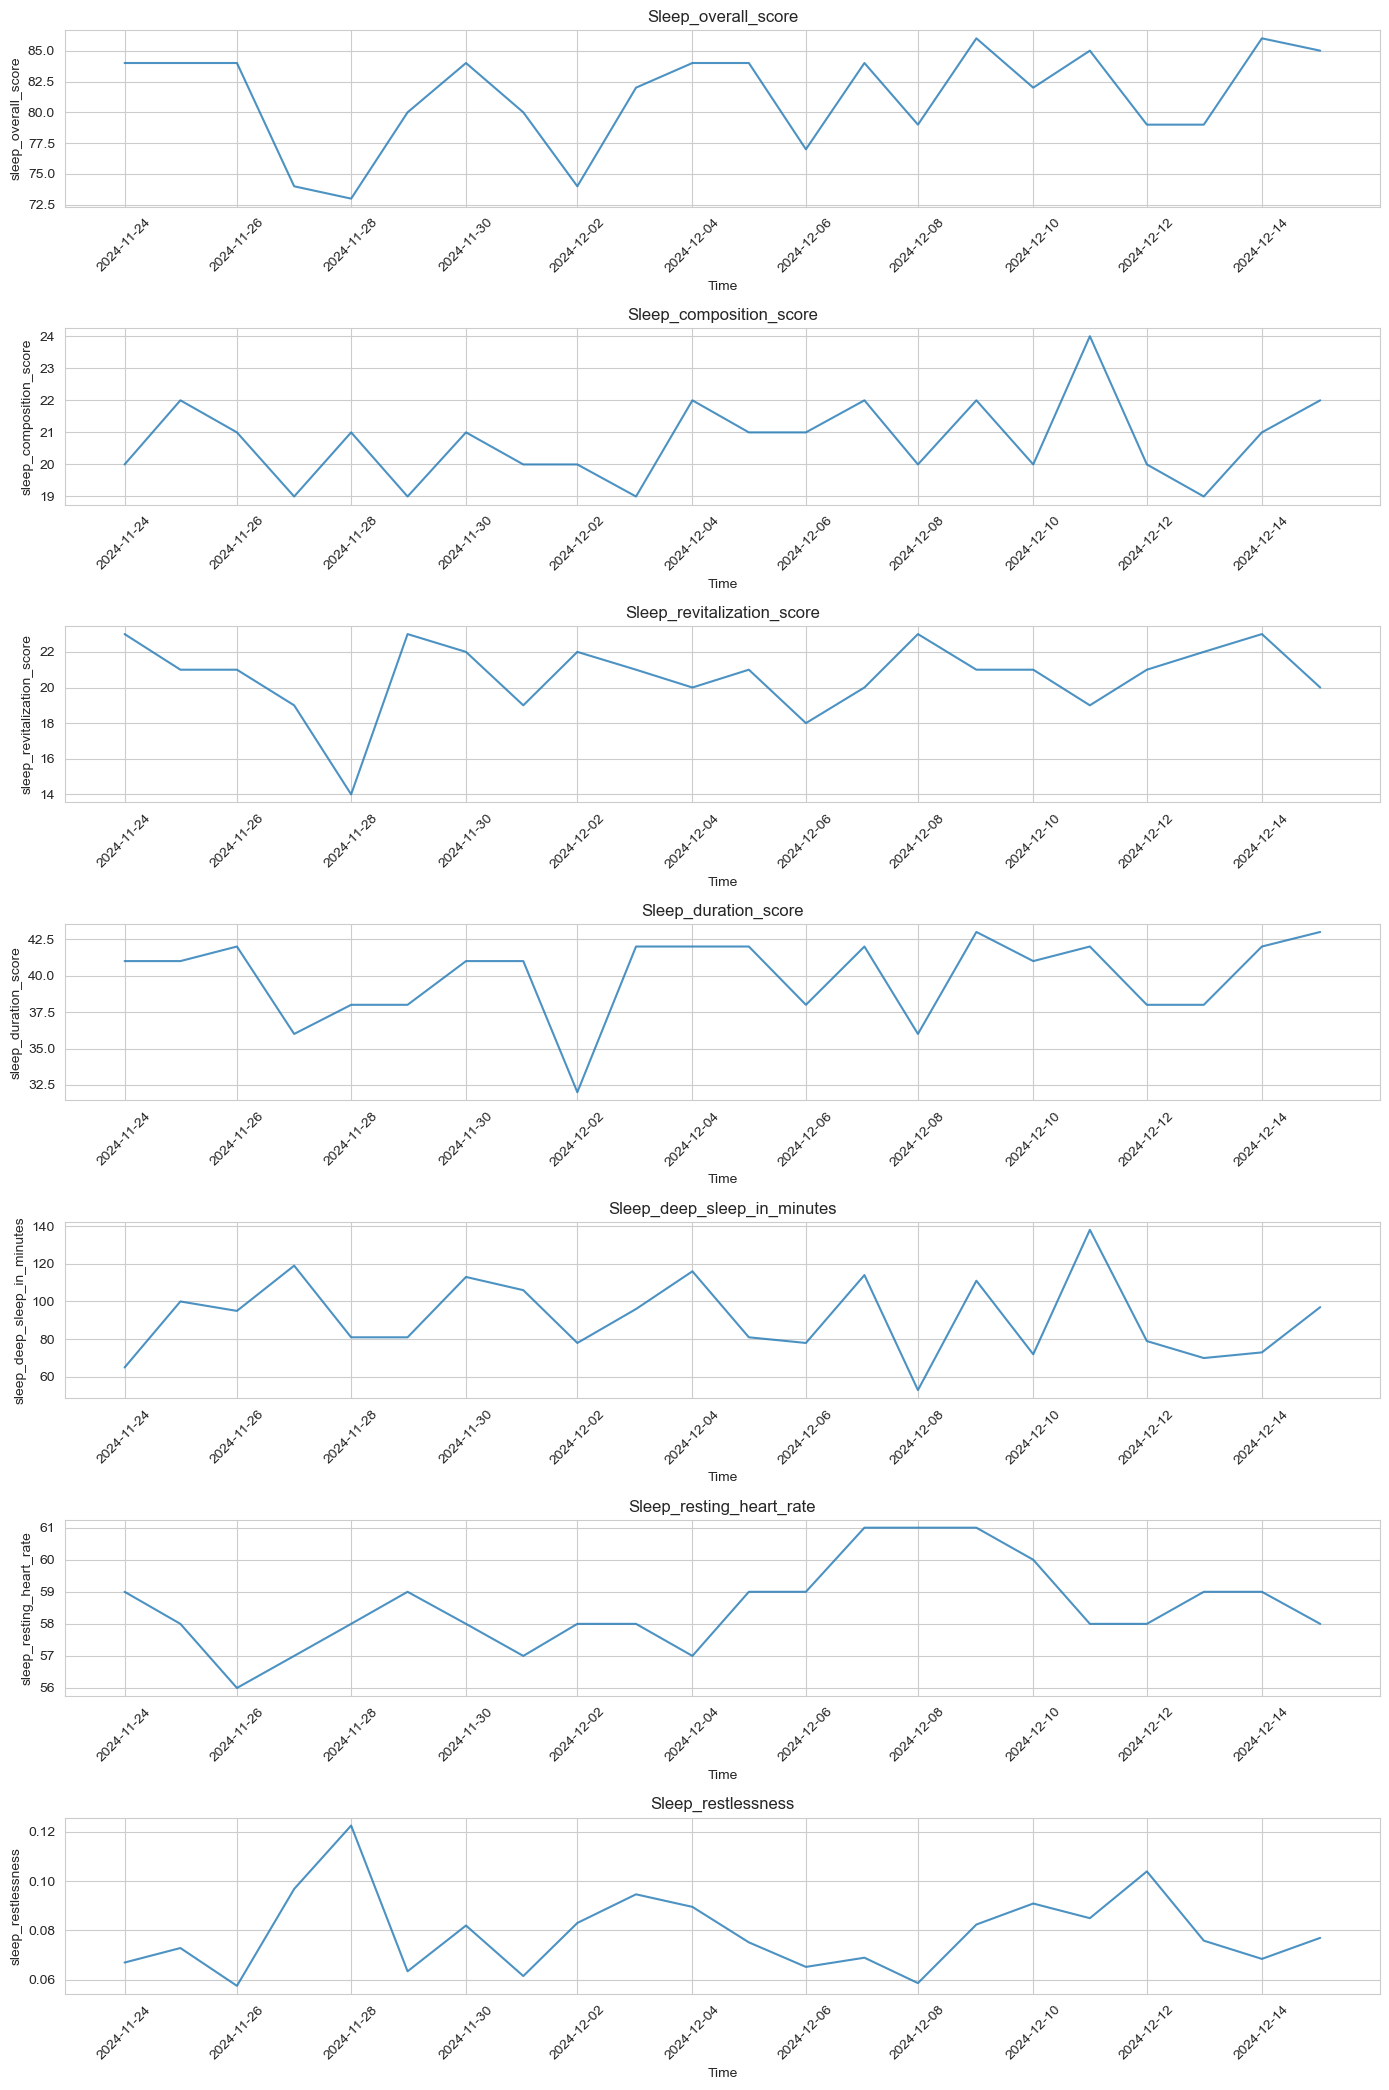

In [87]:
sleep_files = filter(
    lambda p: "sleep_score" in p.parts[-1], data_collection["Sleep Score"]
)


query = (
    pl.scan_csv(list(sleep_files), schema_overrides={"timestamp": pl.Datetime})
    .sort(by="timestamp")
    .drop("sleep_log_entry_id")
).select(pl.col("*").name.prefix("sleep_"))

query = query.with_columns(pl.col("sleep_timestamp").dt.date().alias("date"))

sleep_df = query.collect()


plot_time_series_all_columns(sleep_df, "sleep_timestamp", "date")

In [88]:
height_data = list(
    filter(
        lambda s: "height" in str(s.parts[-1]), data_collection["Global Export Data"]
    )
)
buf: list[pd.DataFrame] = []

for file in height_data:
    buf.append(pd.read_json(file))

height_df_pd = pd.concat(buf).sort_values(by="dateTime", ascending=False)
height_meters = height_df_pd.iloc[0, 1] / 1000.0
print("User Height in meters: ", height_meters)

User Height in meters:  1.84


In [89]:
weight_data = list(
    filter(
        lambda s: "weight" in str(s.parts[-1]), data_collection["Global Export Data"]
    )
)
buf: list[pd.DataFrame] = []

for file in weight_data:
    buf.append(pd.read_json(file).drop(columns=["logId", "source"]))

weight_df = pl.DataFrame(
    pd.concat(buf).sort_values(by=["date", "time"], ascending=False)
)
weight_df = weight_df.rename({"weight": "weight_lb"})
weight_df = weight_df.with_columns((pl.col("weight_lb") * 0.453592).alias("weight_kg"))
weight_df = weight_df.with_columns(pl.col("date").dt.date())
weight_df

weight_lb,bmi,date,time,weight_kg
f64,f64,date,str,f64
205.2,27.5,2024-12-12,"""13:56:08""",93.077078
205.6,27.56,2024-12-10,"""11:44:36""",93.258515
206.3,27.65,2024-12-04,"""13:20:35""",93.57603
207.4,27.79,2024-12-01,"""17:05:28""",94.074981
202.8,27.17,2024-11-24,"""23:59:59""",91.988458
204.3,27.38,2024-11-24,"""16:05:33""",92.668846


In [90]:
lib3_files = libre3data.glob("*.csv")

q = (
    pl.scan_csv(
        list(lib3_files),
        comment_prefix="Glucose Data,Generated on",
        schema_overrides={"Device Timestamp": pl.Datetime},
    )
    .select(pl.col("Device Timestamp", "Historic Glucose mg/dL"))
    .drop_nulls(subset=["Historic Glucose mg/dL"])
    .rename(
        {"Device Timestamp": "timestamp", "Historic Glucose mg/dL": "glucose[mg/dL]"}
    )
    .sort(by="timestamp")
)

gcm_df = q.collect()


q = gcm_df.with_columns(
    pl.col("glucose[mg/dL]").rolling_mean(window_size=12).alias("rolling_mean")
).lazy()

q = q.with_columns(
    (
        (
            (pl.col("glucose[mg/dL]") - pl.col("rolling_mean")) / pl.col("rolling_mean")
        ).abs()
    ).alias("percent_change")
)

q = q.with_columns((pl.col("percent_change") > 0.25).cast(pl.Int32).alias("is_spike"))

gcm_df_agg = (
    q.group_by_dynamic("timestamp", every="1d")
    .agg(
        pl.col("glucose[mg/dL]").mean().alias("mean_glucose"),
        pl.col("glucose[mg/dL]").median().alias("median_glucose"),
        pl.col("glucose[mg/dL]").std().alias("std_glucose"),
        pl.col("glucose[mg/dL]").min().alias("min_glucose"),
        pl.col("glucose[mg/dL]").max().alias("max_glucose"),
        pl.col("is_spike").sum().alias("num_spikes"),  # Count spikes per day
    )
    .collect()
)


gcm_df_agg

timestamp,mean_glucose,median_glucose,std_glucose,min_glucose,max_glucose,num_spikes
datetime[μs],f64,f64,f64,i64,i64,i32
2024-12-12 00:00:00,115.16129,105.0,20.877031,95,194,7
2024-12-13 00:00:00,107.8223,106.0,11.994745,78,152,6
2024-12-14 00:00:00,102.138889,98.0,16.336023,78,151,11
2024-12-15 00:00:00,92.967742,94.0,11.507884,60,125,2


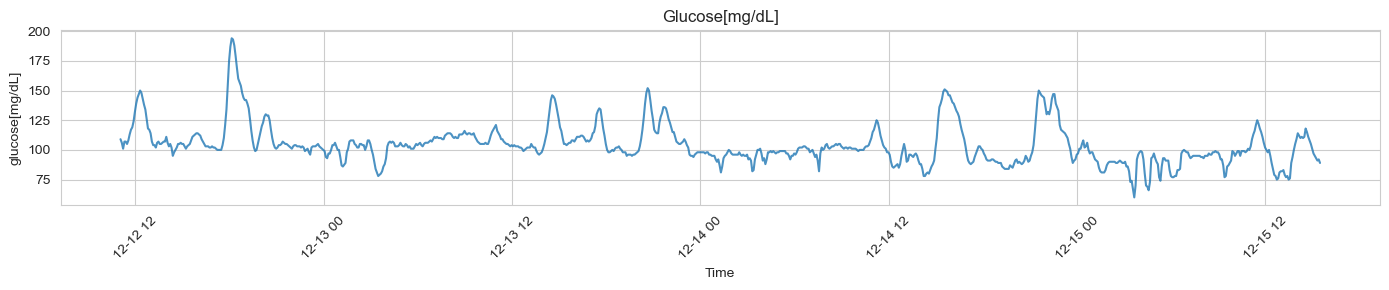

In [91]:
plot_time_series_all_columns(gcm_df, "timestamp")

In [92]:
df = (
    steps_df.select(pl.col(["timestamp", "steps"]))
    .join(hrv_df.select(pl.col(["timestamp", "mean_rmsd"])), on="timestamp")
    .join(sp02_df.select(pl.col(["timestamp", "median_sp02"])), on="timestamp")
    .join(gcm_df_agg, on="timestamp", how="left")
)

df = df.with_columns(pl.col("timestamp").dt.date().alias("date"))

df = df.join(weight_df.drop("time"), on="date", how="left")
df = df.join(sleep_df, on="date")
df = df.drop("date", "sleep_timestamp")
df = df.with_columns(pl.col("timestamp").dt.date().alias("date")).drop("timestamp")
df = df.select([pl.col("date"), pl.exclude("date")])
df

date,steps,mean_rmsd,median_sp02,mean_glucose,median_glucose,std_glucose,min_glucose,max_glucose,num_spikes,weight_lb,bmi,weight_kg,sleep_overall_score,sleep_composition_score,sleep_revitalization_score,sleep_duration_score,sleep_deep_sleep_in_minutes,sleep_resting_heart_rate,sleep_restlessness
date,i64,f64,f64,f64,f64,f64,i64,i64,i32,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64
2024-11-24,10188,76.533101,95.6,null,null,null,null,null,null,202.8,27.17,91.988458,84,20,23,41,65,59,0.067005
2024-11-24,10188,76.533101,95.6,null,null,null,null,null,null,204.3,27.38,92.668846,84,20,23,41,65,59,0.067005
2024-11-25,7635,86.195319,96.2,null,null,null,null,null,null,null,null,null,84,22,21,41,100,58,0.072886
2024-11-26,11226,63.226383,96.1,null,null,null,null,null,null,null,null,null,84,21,21,42,95,56,0.057569
2024-11-27,6860,73.621813,96.0,null,null,null,null,null,null,null,null,null,74,19,19,36,119,57,0.096807
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-10,14810,79.337653,96.2,null,null,null,null,null,null,205.6,27.56,93.258515,82,20,21,41,72,60,0.090909
2024-12-11,7930,100.379667,96.6,null,null,null,null,null,null,null,null,null,85,24,19,42,138,58,0.084974
2024-12-12,10714,80.040596,96.3,115.16129,105.0,20.877031,95,194,7,205.2,27.5,93.077078,79,20,21,38,79,58,0.103924


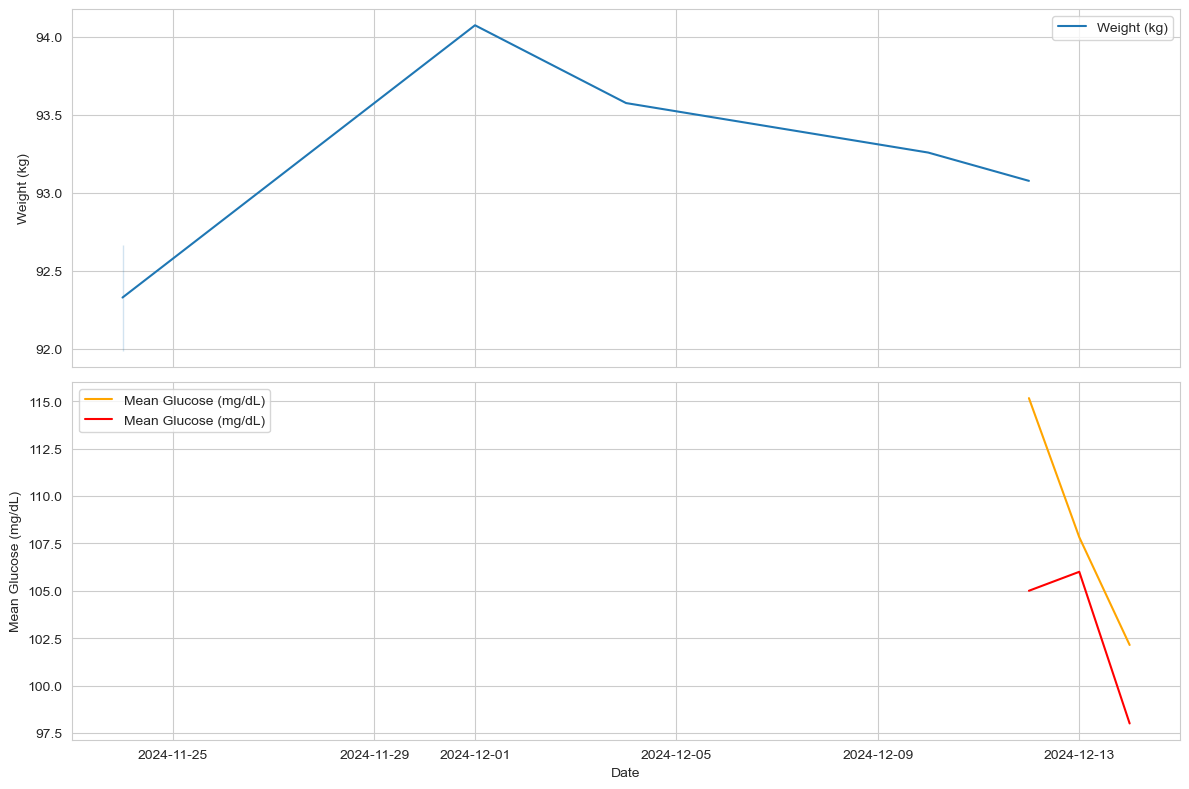

In [133]:
weigh_glucose_df = df.select(
    [
        pl.col("date"),
        pl.col("weight_kg"),
        pl.col("mean_glucose"),
        pl.col("median_glucose"),
    ]
).to_pandas()

fig, (wax, gax) = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))

# Plot weight on the first subplot
sns.lineplot(
    data=weigh_glucose_df, x="date", y="weight_kg", ax=wax, label="Weight (kg)"
)
wax.set_ylabel("Weight (kg)")
wax.legend()
wax.grid(True)

# Plot glucose on the second subplot
sns.lineplot(
    data=weigh_glucose_df,
    x="date",
    y="mean_glucose",
    ax=gax,
    label="Mean Glucose (mg/dL)",
    color="orange",
)
sns.lineplot(
    data=weigh_glucose_df,
    x="date",
    y="median_glucose",
    ax=gax,
    label="Mean Glucose (mg/dL)",
    color="red",
)

gax.set_ylabel("Mean Glucose (mg/dL)")
gax.set_xlabel("Date")
gax.legend()
gax.grid(True)

fig.set_tight_layout(True)

In [140]:
df_corr = df.drop("date").to_pandas().corr()
df_corr

,steps,mean_rmsd,median_sp02,mean_glucose,median_glucose,std_glucose,min_glucose,max_glucose,num_spikes,weight_lb,bmi,weight_kg,sleep_overall_score,sleep_composition_score,sleep_revitalization_score,sleep_duration_score,sleep_deep_sleep_in_minutes,sleep_resting_heart_rate,sleep_restlessness
steps,1.000000,-0.080706,6.524646e-02,-0.519517,-0.951512,0.402880,-0.095809,-0.116068,0.971925,0.167453,0.185039,0.167453,0.207487,-1.338516e-01,0.357510,0.085567,-0.426186,0.219197,-0.226858
mean_rmsd,-0.080706,1.000000,1.278374e-01,0.333735,0.868462,-0.581591,-0.109844,-0.089572,-0.903238,-0.609042,-0.593743,-0.609042,0.374702,7.709757e-02,0.517286,0.107629,0.206139,-0.032038,0.024032
median_sp02,0.065246,0.127837,1.000000e+00,-0.769401,-0.165312,-0.964288,-0.970725,-0.965630,0.090784,0.943205,0.937681,0.943205,-0.156053,-4.284125e-15,-0.180982,-0.085998,0.075556,-0.075978,0.069110
mean_glucose,-0.519517,0.333735,-7.694009e-01,1.000000,0.757169,0.572744,0.900304,0.908984,-0.705978,NaN,NaN,NaN,-0.827100,-4.352624e-01,-0.997317,-0.827100,0.708234,-0.900304,0.968560
median_glucose,-0.951512,0.868462,-1.653116e-01,0.757169,1.000000,-0.101803,0.397360,0.415973,-0.997176,NaN,NaN,NaN,-0.993399,-9.176629e-01,-0.802955,-0.993399,0.075094,-0.397360,0.570857
std_glucose,0.402880,-0.581591,-9.642884e-01,0.572744,-0.101803,1.000000,0.872443,0.862306,0.176219,NaN,NaN,NaN,-0.012981,4.887157e-01,-0.511200,-0.012981,0.984351,-0.872443,0.758669
min_glucose,-0.095809,-0.109844,-9.707253e-01,0.900304,0.397360,0.872443,1.000000,0.999792,-0.327327,NaN,NaN,NaN,-0.500000,0.000000e+00,-0.866025,-0.500000,0.944911,-1.000000,0.980282
max_glucose,-0.116068,-0.089572,-9.656305e-01,0.908984,0.415973,0.862306,0.999792,1.000000,-0.346509,NaN,NaN,NaN,-0.517540,-2.037284e-02,-0.876032,-0.517540,0.938046,-0.999792,0.984105
num_spikes,0.971925,-0.903238,9.078413e-02,-0.705978,-0.997176,0.176219,-0.327327,-0.346509,1.000000,NaN,NaN,NaN,0.981981,9.449112e-01,0.755929,0.981981,0.000000,0.327327,-0.507589
weight_lb,0.167453,-0.609042,9.432051e-01,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.999737,1.000000,-0.498231,3.169708e-01,-0.951021,0.113045,0.809374,-0.613531,0.125585


In [142]:
high_corr = (df_corr.abs() > 0.9) & (df_corr != 1)

high_corr_pairs = [
    (row, col, df_corr.loc[row, col])
    for row, col in high_corr.stack().loc[lambda x: x].index
]

for var1, var2, corr_value in high_corr_pairs:
    print(f"Correlation between {var1} and {var2}: {corr_value:.2f}")

Correlation between steps and median_glucose: -0.95
Correlation between steps and num_spikes: 0.97
Correlation between mean_rmsd and num_spikes: -0.90
Correlation between median_sp02 and std_glucose: -0.96
Correlation between median_sp02 and min_glucose: -0.97
Correlation between median_sp02 and max_glucose: -0.97
Correlation between median_sp02 and weight_lb: 0.94
Correlation between median_sp02 and bmi: 0.94
Correlation between median_sp02 and weight_kg: 0.94
Correlation between mean_glucose and min_glucose: 0.90
Correlation between mean_glucose and max_glucose: 0.91
Correlation between mean_glucose and sleep_revitalization_score: -1.00
Correlation between mean_glucose and sleep_resting_heart_rate: -0.90
Correlation between mean_glucose and sleep_restlessness: 0.97
Correlation between median_glucose and steps: -0.95
Correlation between median_glucose and num_spikes: -1.00
Correlation between median_glucose and sleep_overall_score: -0.99
Correlation between median_glucose and sleep_co